# Set Environment & Libraries

In [8]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import os       # operating system, eg. file path...
# import warnings

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
import seaborn as sns
sns.set_style('whitegrid')
# from plotly import tools
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# import plotly.figure_factory as ff

# Modelling
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA


# Feature engineering
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# Model support functions
import math
from numpy.random import normal, seed
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Data

In [9]:
df = pd.read_csv('/Users/songyarong/Workspace/5. Project/8. Time Series/MSFT_Stock.csv', index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


# Data Exploration

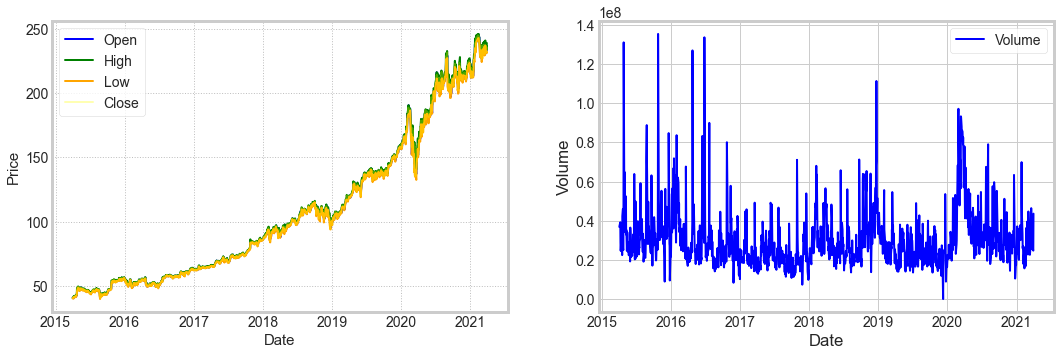

In [10]:
fig,ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].plot(df['Open'], color='blue',label='Open', linewidth=2)
ax[0].plot(df['High'], color='green',label='High', linewidth=2)
ax[0].plot(df['Low'], color='orange',label='Low', linewidth=2)
ax[0].plot(df['Close'], color='yellow',label='Close',alpha = 0.3, linewidth=2)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')
ax[0].grid(color='gray', alpha=0.5, linestyle='dotted')
# ax.grid(False)
ax[0].xaxis.label.set_size(15)
ax[0].yaxis.label.set_size(15)
ax[0].legend()

ax[1].plot(df['Volume'], color='blue', linewidth=2, label='Volume')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volume')
ax[1].legend()

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

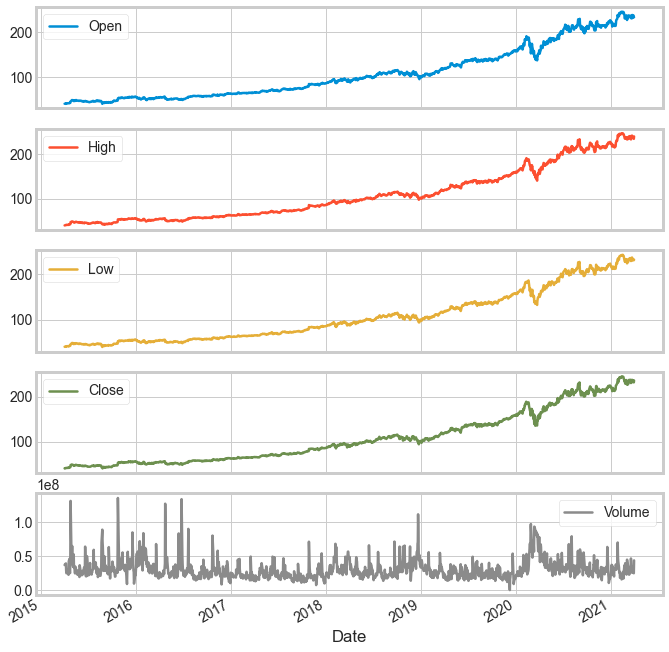

In [11]:
# DataFrame 直接画图
df.plot(subplots=True, figsize= (10,12), linewidth=2.5)

In [12]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [13]:
# Check missing value
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [14]:
df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


# De-trend

## Division

<AxesSubplot:xlabel='Date'>

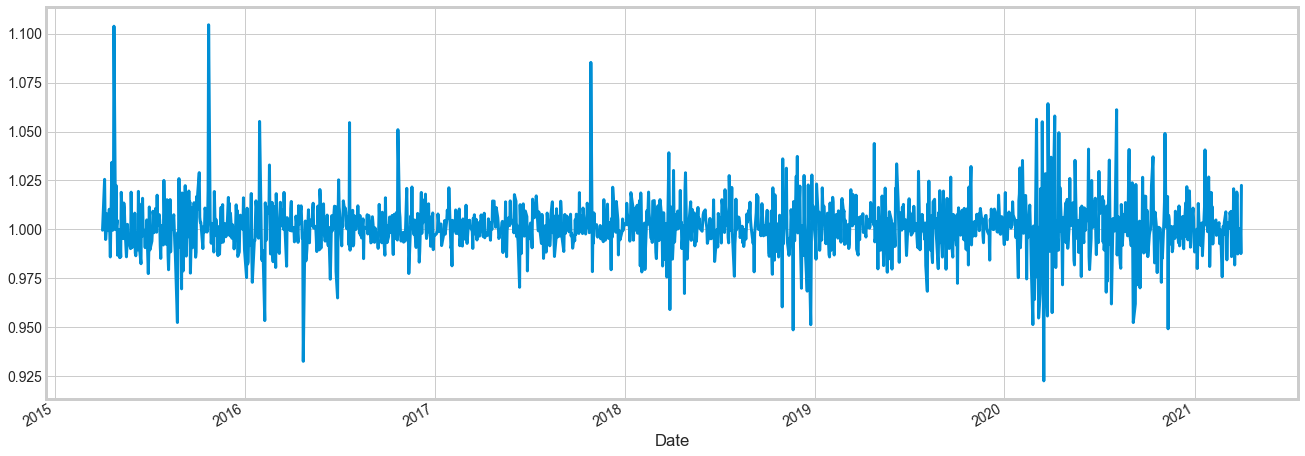

In [15]:
# division
df['div_High'] = df.High.div(df.High.shift())
df['div_High'].plot(figsize=(20,8), linewidth=3)

<AxesSubplot:xlabel='Date'>

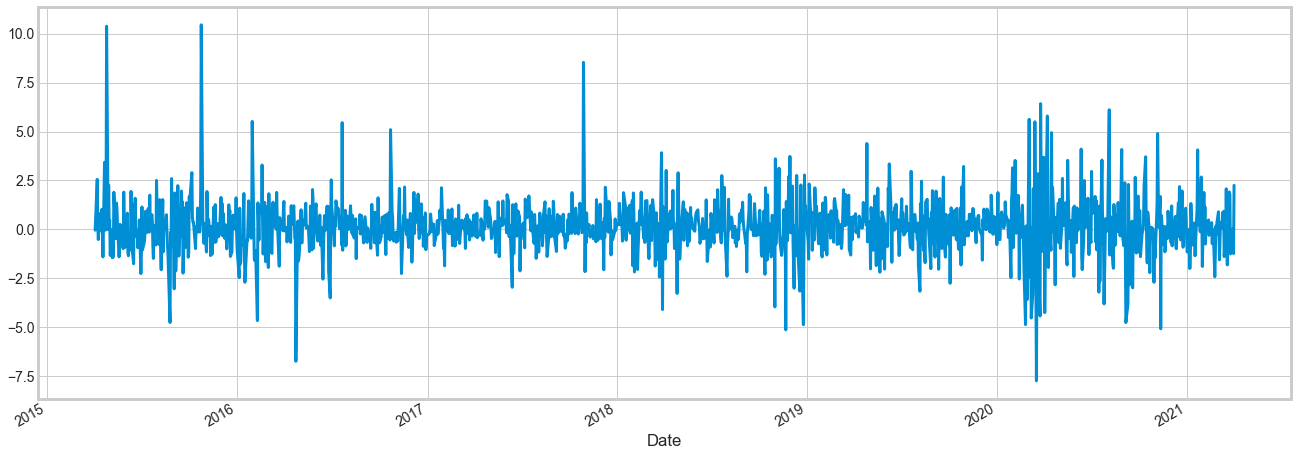

In [16]:
df['Return'] = df.div_High.sub(1).mul(100)
df['Return'].plot(figsize=(20,8), linewidth=3)

## Trend: rolling mean and std

In [17]:
# Use rolling mean to retrieve the trend
# rolling can deal with some of the missing data
rollingmean = df.High.rolling(window='90D').mean()
rollingstd = df.High.rolling(window='90D').std()

Text(0.5, 1.0, 'Rolling Mean')

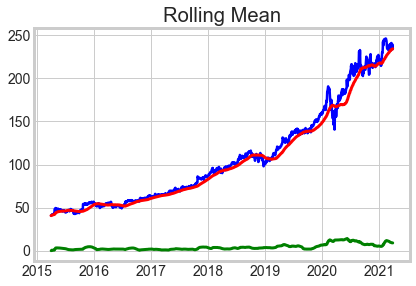

In [18]:
plt.plot(df['High'], color='blue', linewidth=2.5, label='Original')
plt.plot(rollingmean, color='red', linewidth=3, label='Rolling Mean')
plt.plot(rollingstd, color='green', linewidth=3, label='Rolling std')
plt.title('Rolling Mean')

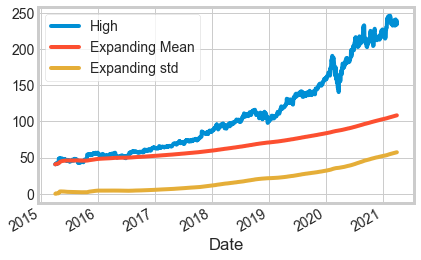

In [19]:
# Window calculation
# Expanding mean and std
expanding_mean = df.High.expanding().mean()
expanding_std = df.High.expanding().std()
df.High.plot()
expanding_mean.plot()
expanding_std.plot()
plt.legend(['High', 'Expanding Mean', 'Expanding std'])

## Seasonal cycle

In [20]:
# Resampling
# Missing data
y = df['High'].resample('D').mean()
y = y.fillna(method='bfill')
y = y.fillna(method='ffill')

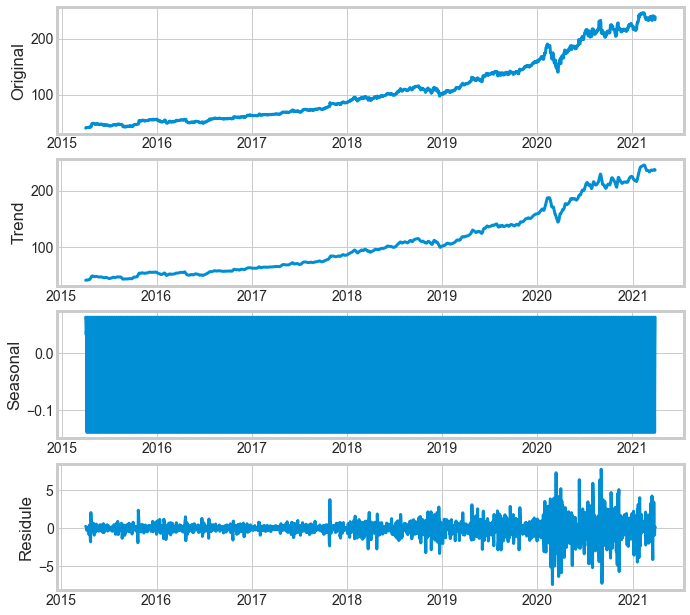

In [21]:
# decompose: 1) Trend; 2) Seasonal; 3) Residual
deco = sm.tsa.seasonal_decompose(y, model='additive')
fig,ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(y, linewidth=3)
ax[0].set_ylabel("Original")
ax[1].plot(deco.trend, linewidth=3)
ax[1].set_ylabel("Trend")
ax[2].plot(deco.seasonal,linewidth=3)
ax[2].set_ylabel("Seasonal")
ax[3].plot(deco.resid,linewidth=3)
ax[3].set_ylabel("Residule")
# deco.plot()
plt.show()

# No seanonal/cyclic pattern by day

# Modelling: Close price

## New DataFrame

In [22]:
df2 = pd.read_csv('/Users/songyarong/Workspace/5. Project/8. Time Series/MSFT_Stock.csv')
df2.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [23]:
df2['dateN'] = pd.to_datetime(df2['Date'])
df2.set_index('dateN', inplace=True)
df2.head()

,Date,Open,High,Low,Close,Volume
dateN,,,,,,
2015-04-01 16:00:00,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


## Decompose

dateN
2015-04-01     40.72
2015-04-02     40.29
2015-04-03       NaN
2015-04-04       NaN
2015-04-05       NaN
               ...  
2021-03-27       NaN
2021-03-28       NaN
2021-03-29    235.24
2021-03-30    231.85
2021-03-31    235.77
Freq: D, Name: Close, Length: 2192, dtype: float64

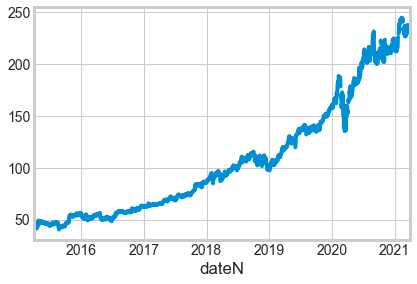

In [24]:
y = df2['Close'].resample('D').mean()   # by day
y.plot()
y

dateN
2015-12-31     47.729476
2016-12-31     55.259325
2017-12-31     71.984024
2018-12-31    101.033984
2019-12-31    130.383571
2020-12-31    193.026126
2021-12-31    232.021475
Freq: A-DEC, Name: Close, dtype: float64

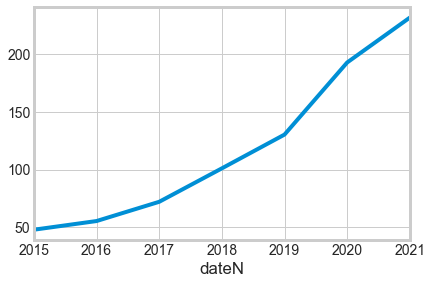

In [25]:
y = df2['Close'].resample('Y').mean()   # by year
y.plot()
y

<ipython-input-26-df389e0f378c>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  deco = sm.tsa.seasonal_decompose(df2['Close'], model='additive',freq=360) # The frequncy is annual


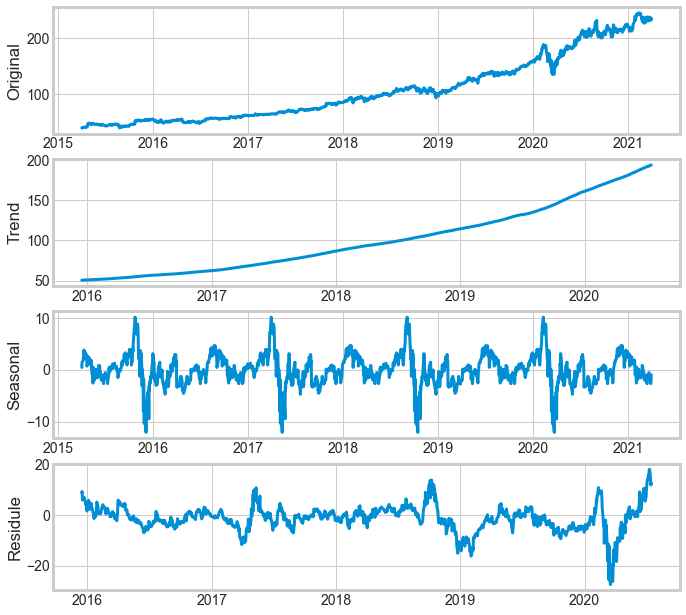

In [26]:
# Deal with missing data first
# annual data pattern
deco = sm.tsa.seasonal_decompose(df2['Close'], model='additive',freq=360) # The frequncy is annual
fig,ax = plt.subplots(4, 1, figsize=(10,10))
ax[0].plot(df2['Close'], linewidth=3)
ax[0].set_ylabel("Original")
ax[1].plot(deco.trend, linewidth=3)
ax[1].set_ylabel("Trend")
ax[2].plot(deco.seasonal,linewidth=3)
ax[2].set_ylabel("Seasonal")
ax[3].plot(deco.resid,linewidth=3)
ax[3].set_ylabel("Residule")
# deco.plot()
plt.show()

In [27]:
# # monthly data pattern
# deco = sm.tsa.seasonal_decompose(df2['Close'], model='additive',freq=30) # The frequncy is annual
# fig,ax = plt.subplots(4, 1, figsize=(10,10))
# ax[0].plot(df2['Close'], linewidth=3)
# ax[0].set_ylabel("Original")
# ax[1].plot(deco.trend, linewidth=3)
# ax[1].set_ylabel("Trend")
# ax[2].plot(deco.seasonal,linewidth=3)
# ax[2].set_ylabel("Seasonal")
# ax[3].plot(deco.resid,linewidth=3)
# ax[3].set_ylabel("Residule")
# # deco.plot()
# plt.show()

In [28]:
# Explore the residule
deco.resid.describe()

count    1151.000000
mean       -1.202592
std         5.044429
min       -27.418763
25%        -3.551944
50%        -0.850472
75%         1.400378
max        18.115929
Name: resid, dtype: float64

In [29]:
deco.resid.isnull().sum()

360

In [30]:
residual = deco.resid
residual = residual.dropna()  

In [31]:
residual.describe()

count    1151.000000
mean       -1.202592
std         5.044429
min       -27.418763
25%        -3.551944
50%        -0.850472
75%         1.400378
max        18.115929
Name: resid, dtype: float64

In [32]:
residual.isnull().sum()

0

<AxesSubplot:xlabel='dateN'>

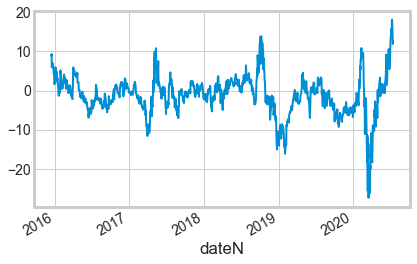

In [33]:
residual.plot(linewidth=2)

In [34]:
# Calculate the ADF of residual
ADFresult = adfuller(residual)
print('ADF statistic: %f' % ADFresult[0])
print('p-value: %f' % ADFresult[1])
print('Critical values:')
for key, value in ADFresult[4].items():
    print('\t%s; %.3f' % (key, value))

ADF statistic: -5.493650
p-value: 0.000002
Critical values:
	1%; -3.436
	5%; -2.864
	10%; -2.568


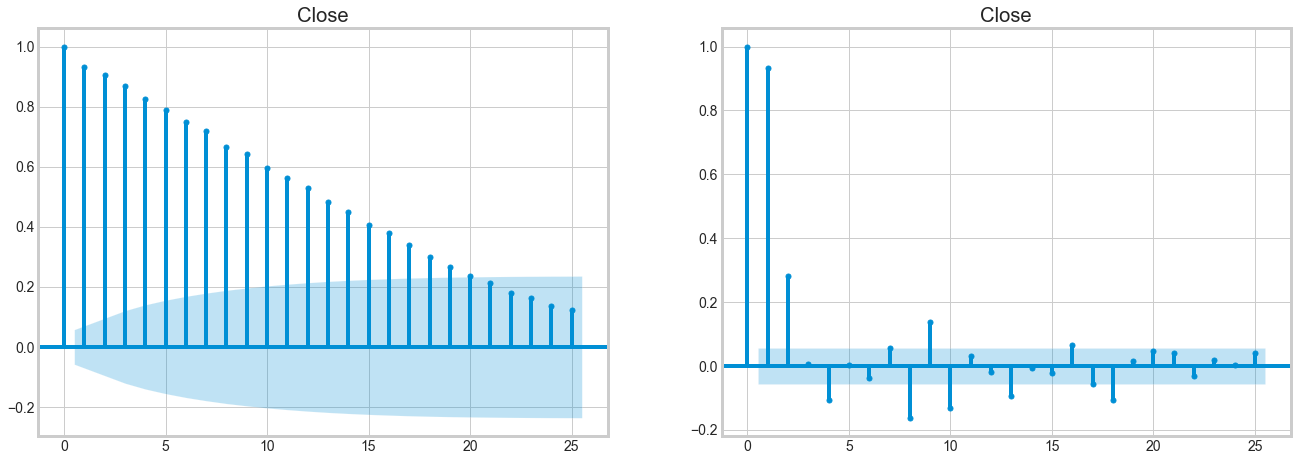

In [35]:
fig,ax = plt.subplots(1, 2, figsize=(20,7))
plot_acf(residual,lags=25,title="Close",ax=ax[0])
plot_pacf(residual,lags=25,title="Close",ax=ax[1])
plt.show()

# ACF: tail off 
# PACF: cut off

## Modelling

### Check if the raw data is stationary

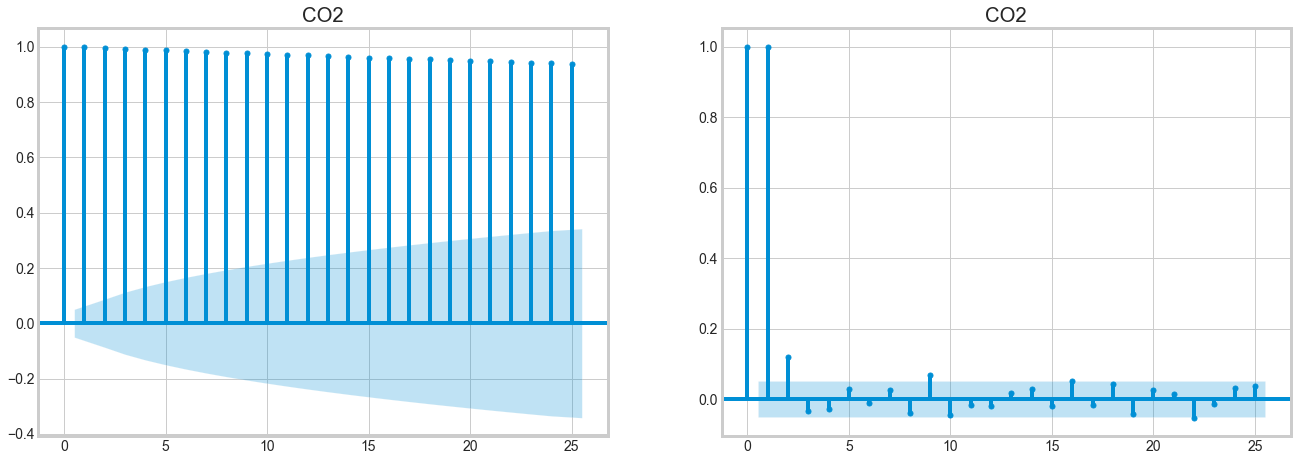

In [36]:
# In comparison, the original data is not stationary
fig,ax = plt.subplots(1, 2, figsize=(20,7))
plot_acf(df['Close'],lags=25,title="CO2",ax=ax[0])
plot_pacf(df['Close'],lags=25,title="CO2",ax=ax[1])
plt.show()

# acf: tail off
# pacf: cut off 2

In [37]:
ADF_raw = adfuller(df['Close'])
ADF_raw

# the original data is not stationary

(1.737136289927097,
 0.9982158366942122,
 24,
 1486,
 {'1%': -3.4347582315402434,
  '5%': -2.863486949792871,
  '10%': -2.567806534528638},
 6604.225695235948)

### First_order differencing

<AxesSubplot:xlabel='Date'>

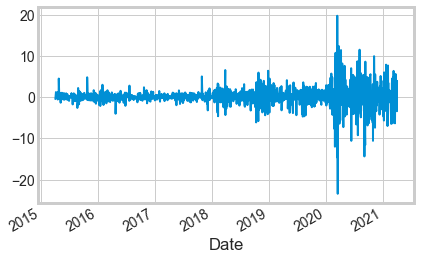

In [38]:
# Differencing on the original data
d1 = df['Close'].diff().dropna()
d1.plot(linewidth= 2)

In [39]:
ADF_d1 = adfuller(d1)
ADF_d1
# first_order differencing is enough

(-10.03833106514641,
 1.5195939917531174e-17,
 24,
 1485,
 {'1%': -3.43476120520139,
  '5%': -2.863488262178673,
  '10%': -2.567807233388883},
 6597.0173474503645)

### Select p, d, q

In [40]:
y = df2['Close'].astype(float)
pmax = int(len(y)/300)         # 一般阶数不超过length/10
qmax = int(len(y)/300)         # 一般阶数不超过length/10
bic_matrix = []               # BIC矩阵
for p in range(pmax+1):
    tmp = []
    for q in range(qmax + 1):
        try:                  # 存在部分报错，用try来跳过报错
            tmp.append(ARIMA(y,(p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, 

/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.

/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, 

/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, 

/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, 

In [41]:
bic_matrix = pd.DataFrame(bic_matrix)   # 从中可以找出最小值
bic_matrix
# left: p 1
# top: q  0

,0,1,2,3,4,5
0,6887.425684,6786.698014,6780.828240,6787.923831,6791.172129,6793.625590
1,6776.344501,6783.659939,6788.040639,6780.205830,6785.988032,6793.228369
2,6783.658391,6774.170342,6769.397849,6747.797012,6783.840424,6793.972035
3,6787.504919,6775.765555,6746.263180,6768.639036,6756.781992,6759.311648
4,6794.506849,6782.480095,6782.246476,6783.673782,6756.317758,NaN
5,6801.356136,6783.995193,6752.984728,6758.404079,6761.620065,NaN


### SARIMAX model

In [42]:
mod = sm.tsa.statespace.SARIMAX(y, order=(2,1,0))
result = mod.fit()

/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/songyarong/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


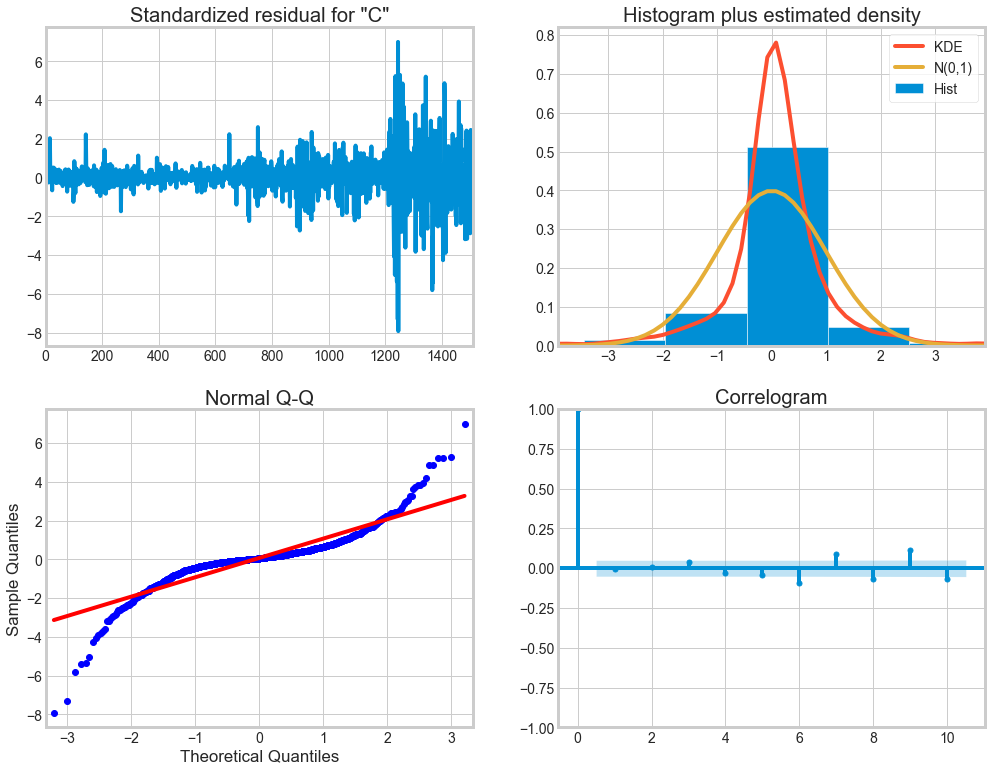

In [43]:
result.plot_diagnostics(figsize=(15, 12))
plt.show()

### Prediction

In [44]:
pred = result.get_prediction(start=1000, dynamic=False)
pred_ci = pred.conf_int()   

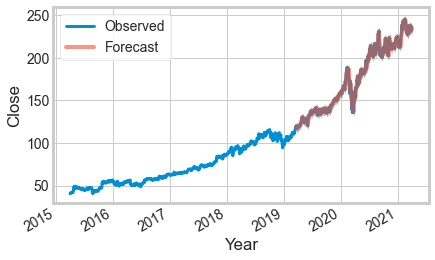

In [45]:
y['2000':].plot(label='Observed', linewidth=3)
pred.predicted_mean.plot(label='Forecast', alpha=0.6)

plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend()
plt.show()

In [46]:
pred = result.get_prediction(start=1000, dynamic=False)
pred_ci

,lower Close,upper Close
dateN,,
2019-03-22 16:00:00,115.041535,123.942990
2019-03-25 16:00:00,113.471961,122.373416
2019-03-26 16:00:00,113.022332,121.923787
2019-03-27 16:00:00,113.396351,122.297806
2019-03-28 16:00:00,112.627939,121.529394
...,...,...
2021-03-25 16:00:00,231.591353,240.492808
2021-03-26 16:00:00,228.713931,237.615386
2021-03-29 16:00:00,230.892460,239.793915
